In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from MemSE.utils import count_parameters, n_vars_computation
from MemSE.model_load import load_model
from MemSE.dataset import get_dataloader
from MemSE.network_manipulations import conv_to_fc
from MemSE.mse_functions import _problem_function_batched
from MemSE.MemristorQuant import MemristorQuant

train_loader, valid_loader, test_loader, nclasses, input_shape = get_dataloader('CIFAR10')
model = load_model('smallest_vgg', nclasses)
model = conv_to_fc(model, input_shape)
batch, _ = next(iter(test_loader))
n_vars_column, n_vars_layer = n_vars_computation(model)
with torch.no_grad():
    z = model(batch).cpu().detach()
sigma = 0.01
r = 1
N = 100
wmax_mode = 'network'
args = (model, sigma, r, N, wmax_mode)

def mse(tensor, ref):
    return torch.square(ref-tensor)
    # return torch.mean(torch.amax(torch.square(ref-tensor), dim=1), dim=0)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Loading model checkpoint


In [2]:
%%time
# COMPUTE MSE WITH METHOD 
# TIME + ONE INFERENCE (HIDDEN COST HERE)
_, mse_th = _problem_function_batched(np.ones(n_vars_layer), args, x=batch, z=z)

CPU times: user 2min 4s, sys: 26.9 s, total: 2min 31s
Wall time: 35.1 s


In [3]:
quanter = MemristorQuant(model, N = N, wmax_mode=wmax_mode, Gmax=np.ones(n_vars_layer), std_noise = sigma)
quanter.quant()

In [4]:
%%time
# ONE LOOP OF MONTE CARLO
with torch.no_grad():
    quanter.renoise()
    _ = model(batch)

CPU times: user 369 ms, sys: 0 ns, total: 369 ms
Wall time: 189 ms


In [5]:
quanter.unquant()

In [6]:
# PLOT EPSILON NB OF LOOPS
quanter.quant()
mse_per_pass = []
n = 200
mse_i = torch.zeros_like(z)
with torch.no_grad():
    for i in range(n):
        quanter.renoise()
        z_i = model(batch)
        se_i = mse(z_i, z)#.item()
        mse_i = (mse_i * i + se_i)/(i+1)
        mse_per_pass.append(torch.mean(torch.amax(mse_i, dim=1)).item())
        #if len(mse_per_pass) == 0:
        #    mse_per_pass.append(mse_i)
        #else:
        #    mse_per_pass.append(((i)*mse_per_pass[-1]+(mse_i))/(i+1))
    quanter.unquant()

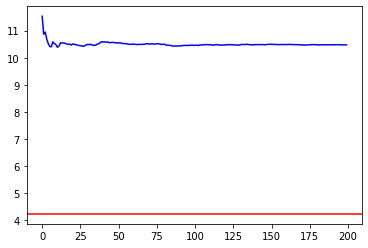

In [7]:
plt.plot(mse_per_pass, color='blue')
plt.axhline(mse_th.item(), color='red')
plt.show()